# 卷积神经网络（LeNet）
## LeNet

总体来看，(**LeNet（LeNet-5）由两个部分组成：**)(~~卷积编码器和全连接层密集块~~)

* 卷积编码器：由两个卷积层组成;
* 全连接层密集块：由三个全连接层组成。  

#### 高宽减半的同时一般把通道数翻倍

![LeNet中的数据流。输入是手写数字，输出为10种可能结果的概率。](../img/lenet.svg)

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    # 第一个卷积层使用2个像素的填充，来补偿卷积核5x5导致的特征减少
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

In [2]:
# 检查模型：通过打印每一层输出的形状
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


## 模型训练
**LeNet在Fashion-MNIST数据集上的表现**

In [3]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

由于完整的数据集位于内存中，因此在模型使用GPU计算数据集之前，需要将其复制到显存中。  

**net.eval()** 和 **with.no_grad()** 在PyTorch中各自扮演不同的角色，并且它们的使用场景和效果也有所区别。  

net.eval()：这个函数用于将神经网络模型切换到评估模式。在评估模式下，模型的行为会发生变化，特别是Batch Normalization和Dropout层的行为。在训练模式下，Batch Normalization和Dropout层会随机地丢弃一些神经元，以增加模型的泛化能力。而在评估模式下，Batch Normalization和Dropout层会保留所有的神经元，以便更好地评估模型的性能。此外，net.eval()还可以用来禁止forward过程对参数造成的影响，例如禁止dropout或者因为测试集和训练集的样本分布不一样，会有batch normalization所带来的影响。  

with.no_grad()：这是一个上下文管理器，用于在评估模式下禁用梯度计算。在评估模式下，我们通常不需要计算梯度，因为我们只是使用模型来进行预测。禁用梯度计算可以减少计算量，提高模型的性能。with.no_grad()可以用来包装一些代码块，以便在该代码块中禁用梯度计算。  

**使用场景**：  

在进行模型验证或测试时，通常会使用net.eval()来切换到测试模式，以确保Batch Normalization和Dropout层的行为符合评估的需求。这种模式下，模型不会进行参数更新，从而能够更准确地评估模型的性能。  

with.no_grad()则主要用于停止autograd模块的工作，以起到加速和节省显存的作用。具体来说，它停止gradient计算，从而节省了GPU算力和显存。然而，这并不会影响dropout和batchnorm层的行为。  

综上所述，net.eval()和with.no_grad()虽然都是用于优化模型性能的工具，但它们的作用机制和使用场景有所不同。在模型评估或测试时，通常建议同时使用这两个功能以确保最佳的性能和准确性。

In [4]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            # 如果是列表的话，需要把每一行移到gpu中
            # 如果是tenser的话，直接移动矩阵即可
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [7]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)# 将net移动到gpu
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device) # 将数据移动到gpu
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (train_l, train_acc, None))# 每5个batch画一个点train loss/train acc
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))# 每1个epoch画一个点 test acc
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, 'f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec 'f'on {str(device)}')

loss 0.483, train acc 0.818, test acc 0.803
5883.8 examples/sec on cpu


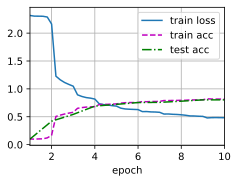

In [8]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())